In [1]:
import sqlite3
import numpy as np
import pandas as pd
import glob
import datetime
# modellen importeren
from sklearn.cluster import AgglomerativeClustering
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Maak verbinding met de database
con = sqlite3.connect(r"D:/School/Schooljaar 2/python/DataRWS/NO_XXX_EVENT_EXPORT/bridges.db", ) # zet hier het path naar je eigen database
cur = con.cursor()

'''
Laad de data van een brug uit de database
WHERE = data inladen vanaf 2016, als je dit niet begrijpt hoe het werkt is het geen probleem
De limit geeft aan dat je maar een bepaald aantal lines wil laden
'''

df = pd.read_sql("SELECT * FROM W5 LIMIT 1000000 OFFSET 23", con)
con.close()

In [3]:
df.tail()

,Tijd,Type,Klasse,Waarde,ID,Omschrijving,Status,Prioriteit,Comment,Tijd_Came,Tijd_Went,Tijd_ack,UUID,DPE
999995,30-06-2016 15:10:04.967,PROCES,,FALSE,,VF_6a : Svs 1 of 2 Rd ---- Svs 3 en 4 Rd Mogen...,,,,,,,0,DB_F_VF-S._04
999996,30-06-2016 15:10:04.967,PROCES,,FALSE,,VF_7 : Svs Rd ---- Brug Mag Bewegen,,,,,,,0,DB_F_VF-S._06
999997,30-06-2016 15:10:04.967,PROCES,,FALSE,,VF_6c : Svs 5 of 6 Rd ---- Svs 7 en 8 Rd Mogen...,,,,,,,0,DB_F_VF-S._16
999998,30-06-2016 15:10:04.967,PROCES,,FALSE,,Scheepvaartsein 3 Rood Safe Doven Safe Vrijgave,,,,,,,0,DB_S11-Svs-1-S.SVS3Rood.Status.Safety.QNRd_FVg
999999,30-06-2016 15:10:04.967,PROCES,,FALSE,,Scheepvaartsein 4 Rood Safe Doven Safe Vrijgave,,,,,,,0,DB_S11-Svs-1-S.SVS4Rood.Status.Safety.QNRd_FVg


In [4]:
df.head()

,Tijd,Type,Klasse,Waarde,ID,Omschrijving,Status,Prioriteit,Comment,Tijd_Came,Tijd_Went,Tijd_ack,UUID,DPE
0,01-12-2015 12:27:20.691,LOG-UIT,,,,Afstand: meekijken,,,,,,,4097,NO_BRUG
1,01-12-2015 12:12:48.281,LOG-IN,,,,Afstand: meekijken,,,,,,,65535,NO_BRUG
2,01-12-2015 11:34:25.877,LOG-IN,,,,Lokaal: meekijken,,,,,,,65535,NO_BRUG
3,01-12-2015 10:55:17.879,LOG-IN,,,,Afstand: hoofdoperator,,,,,,,8,NO_BRUG
4,01-12-2015 10:55:16.293,LOG-UIT,,,,Afstand: meekijken,,,,,,,4097,NO_BRUG


## Windkracht dataframe

In [5]:
wkdf = df[df.Omschrijving == 'Meteo Actuele Windkracht']

wkdf = wkdf[['Tijd', 'Waarde']].copy()
wkdf['Tijd'] = pd.to_datetime(wkdf.Tijd, dayfirst = True)
wkdf['Waarde'] = wkdf.Waarde.astype('float')

# negatieve windkracht heb ik nog nooit gezien, dus die nemen we niet mee
wkdf = wkdf[wkdf.Waarde > 0]
wkdf.columns = ['time','Wk']

# check of alles gelukt is
wkdf.describe()

,Wk
count,11.000000
mean,1.008128
std,0.806542
min,0.151910
25%,0.336372
50%,0.694444
75%,1.443142
max,2.712673


In [6]:
wkdf.tail()

,time,Wk
84700,2015-12-23 16:56:44.760,1.779514
84705,2015-12-23 16:54:42.829,0.694444
84709,2015-12-23 16:52:41.953,1.345486
84715,2015-12-23 16:50:40.169,0.151910
84717,2015-12-23 16:48:38.859,2.712673


## Windrichting

In [7]:
# Haal windrichting data uit standaard df 
wrdf = df[df.Omschrijving == 'Meteo Actuele Windrichting']

# zet de types om naar werkbare types
wrdf['Tijd'] = pd.to_datetime(wrdf.Tijd, dayfirst = True)
wrdf['Waarde'] = wrdf.Waarde.astype('float')

# negatieve windrichtingen bestaan niet
wrdf = wrdf[wrdf.Waarde > 0]

# Maak df met allen tijd en waarde kolom
wrdf = wrdf[['Tijd', 'Waarde']].copy()

# Pas kolom namen aan zodat het later gemerged kan worden en duidelijk blijft
wrdf.columns = ['time','WR']
wrdf.head()

#check of alles gelukt is
wrdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13 entries, 84685 to 970222
Data columns (total 2 columns):
time    13 non-null datetime64[ns]
WR      13 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 312.0 bytes


c:\users\gebruiker\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
c:\users\gebruiker\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## Brug Beweging DataFrame

In [8]:
# Maak een df met daarin alle meldingen die te maken hebben met het openen en sluiten van de brug

OpenSluit = df[df.Omschrijving == 'Brug Beweging Actief']
SluitOpen = OpenSluit.append(df[df.Omschrijving == 'Algemeen Commando Brug Openen'])
OpenSluitBeweging = SluitOpen.append(df[df.Omschrijving == 'Algemeen Commando Brug Sluiten']) 
OpenSluitBeweging.Tijd = pd.to_datetime(OpenSluitBeweging.Tijd, dayfirst = True)

In [9]:
OpenSluitBeweging.head()

,Tijd,Type,Klasse,Waarde,ID,Omschrijving,Status,Prioriteit,Comment,Tijd_Came,Tijd_Went,Tijd_ack,UUID,DPE
236,2015-12-02 19:42:52.203,PROCES,,FALSE,,Brug Beweging Actief,,,,,,,0,DB_A11-Brug-S.Status.BewR
380,2015-12-02 19:41:36.893,PROCES,,TRUE,,Brug Beweging Actief,,,,,,,0,DB_A11-Brug-S.Status.BewR
505,2015-12-02 19:39:32.183,PROCES,,FALSE,,Brug Beweging Actief,,,,,,,0,DB_A11-Brug-S.Status.BewR
619,2015-12-02 19:38:10.076,PROCES,,TRUE,,Brug Beweging Actief,,,,,,,0,DB_A11-Brug-S.Status.BewR
976,2015-12-02 17:53:08.081,PROCES,,FALSE,,Brug Beweging Actief,,,,,,,0,DB_A11-Brug-S.Status.BewR


In [10]:
OpenSluitBeweging.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9446 entries, 236 to 999928
Data columns (total 14 columns):
Tijd            9446 non-null datetime64[ns]
Type            9446 non-null object
Klasse          9446 non-null object
Waarde          9446 non-null object
ID              9446 non-null object
Omschrijving    9446 non-null object
Status          9446 non-null object
Prioriteit      9446 non-null object
Comment         9446 non-null object
Tijd_Came       9446 non-null object
Tijd_Went       9446 non-null object
Tijd_ack        9446 non-null object
UUID            9446 non-null object
DPE             9446 non-null object
dtypes: datetime64[ns](1), object(13)
memory usage: 627.3+ KB


In [11]:
# Sorteer het df op datum. (je sorteert op index omdat Tijd kolom niet mee wilden werken)
Duur = OpenSluitBeweging.sort_index()

In [12]:
Duur.head()

,Tijd,Type,Klasse,Waarde,ID,Omschrijving,Status,Prioriteit,Comment,Tijd_Came,Tijd_Went,Tijd_ack,UUID,DPE
236,2015-12-02 19:42:52.203,PROCES,,FALSE,,Brug Beweging Actief,,,,,,,0,DB_A11-Brug-S.Status.BewR
357,2015-12-02 19:41:39.072,PROCES,,FALSE,,Algemeen Commando Brug Sluiten,,,,,,,0,DB_D00-Algemeen-S.CMD.BrugSl.Cmd
380,2015-12-02 19:41:36.893,PROCES,,TRUE,,Brug Beweging Actief,,,,,,,0,DB_A11-Brug-S.Status.BewR
388,2015-12-02 19:41:36.822,PROCES,,TRUE,,Algemeen Commando Brug Sluiten,,,,,,,40,DB_D00-Algemeen-S.CMD.BrugSl.Cmd
505,2015-12-02 19:39:32.183,PROCES,,FALSE,,Brug Beweging Actief,,,,,,,0,DB_A11-Brug-S.Status.BewR


In [13]:
# Maak een kolom in df met daarin de tijd omgezet naar seconden, zodat het makkelijker rekenen wordt
Duur['seconden'] = (Duur.Tijd.astype(np.int64) // 10**9)

In [14]:
print(Duur)

                          Tijd    Type Klasse Waarde ID  \
236    2015-12-02 19:42:52.203  PROCES         FALSE      
357    2015-12-02 19:41:39.072  PROCES         FALSE      
380    2015-12-02 19:41:36.893  PROCES          TRUE      
388    2015-12-02 19:41:36.822  PROCES          TRUE      
505    2015-12-02 19:39:32.183  PROCES         FALSE      
614    2015-12-02 19:38:10.076  PROCES         FALSE      
619    2015-12-02 19:38:10.076  PROCES          TRUE      
641    2015-12-02 19:38:09.922  PROCES          TRUE      
976    2015-12-02 17:53:08.081  PROCES         FALSE      
1092   2015-12-02 17:51:56.338  PROCES         FALSE      
1102   2015-12-02 17:51:54.176  PROCES          TRUE      
1123   2015-12-02 17:51:54.025  PROCES          TRUE      
1242   2015-12-02 17:50:39.084  PROCES         FALSE      
1347   2015-12-02 17:49:19.302  PROCES         FALSE      
1369   2015-12-02 17:49:17.184  PROCES          TRUE      
1376   2015-12-02 17:49:17.069  PROCES          TRUE    

In [15]:
Duur.to_csv('beweging.csv')

In [16]:
Duur.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9446 entries, 236 to 999928
Data columns (total 15 columns):
Tijd            9446 non-null datetime64[ns]
Type            9446 non-null object
Klasse          9446 non-null object
Waarde          9446 non-null object
ID              9446 non-null object
Omschrijving    9446 non-null object
Status          9446 non-null object
Prioriteit      9446 non-null object
Comment         9446 non-null object
Tijd_Came       9446 non-null object
Tijd_Went       9446 non-null object
Tijd_ack        9446 non-null object
UUID            9446 non-null object
DPE             9446 non-null object
seconden        9446 non-null int64
dtypes: datetime64[ns](1), int64(1), object(13)
memory usage: 701.1+ KB


In [17]:
begin = 0
eind = 0
x = 0
tst = None
sluit = True
duur = list()
oslist = list()
timestamp = list()

for index, row in Duur.iterrows():
    waarde = row[3]
    oms = row[5]
    sec = row[14]
    ts = row[0]
    print(sec)
    if ((oms == 'Brug Beweging Actief') & (waarde == "TRUE")):
        begin = sec
        tst = ts       
    elif ((oms == 'Brug Beweging Actief') & (waarde == "FALSE")):
        eind = sec
    if (oms == 'Algemeen Commando Brug Openen'):
        sluit = False
    elif (oms == 'Algemeen Commando Brug Sluiten'):
        sluit = True
    if ((eind!=0) & (begin!=0)):
        duur.append(eind-begin)
        timestamp.append(ts)
        oslist.append(sluit)
        eind = 0
        begin = 0
    

1449085372
1449085299
1449085296
1449085296
1449085172
1449085090
1449085090
1449085089
1449078788
1449078716
1449078714
1449078714
1449078639
1449078559
1449078557
1449078557
1449075134
1449075062
1449075060
1449075060
1449074837
1449074758
1449074755
1449074755
1449071623
1449071552
1449071549
1449071549
1449071447
1449071368
1449071366
1449071366
1449065900
1449065829
1449065827
1449065826
1449065684
1449065605
1449065602
1449065602
1449065135
1449065064
1449065061
1449065061
1449064951
1449064872
1449064870
1449064869
1449064073
1449064001
1449063999
1449063999
1449063840
1449063758
1449063758
1449063758
1449055015
1449054937
1449054937
1449054937
1449054774
1449054694
1449054692
1449054692
1449044388
1449044315
1449044313
1449044313
1449044165
1449044084
1449044083
1449044083
1449036781
1449036708
1449036706
1449036705
1449036473
1449036392
1449036391
1449036391
1449177205
1449177128
1449177126
1449177126
1449176988
1449176908
1449176905
1449176905
1449169637
1449169561
1449169559

1451908333
1451908331
1451908331
1451897990
1451897911
1451897909
1451897909
1451897811
1451897727
1451897725
1451897725
1452014167
1452014092
1452014092
1452014092
1452013955
1452013874
1452013872
1452013872
1452011382
1452011305
1452011303
1452011303
1452011215
1452011133
1452011131
1452011131
1451985027
1451984955
1451984953
1451984953
1451984877
1451984797
1451984795
1451984795
1451983910
1451983831
1451983829
1451983829
1451983654
1451983572
1451983570
1451983570
1452104227
1452104149
1452104147
1452104147
1452103899
1452103817
1452103815
1452103815
1452089592
1452089520
1452089518
1452089518
1452089456
1452089377
1452089375
1452089374
1452089122
1452089048
1452089048
1452089048
1452088915
1452088835
1452088832
1452088832
1452085282
1452085206
1452085204
1452085204
1452085192
1452085110
1452085108
1452085108
1452078413
1452078341
1452078339
1452078339
1452078270
1452078189
1452078187
1452078187
1452074560
1452074488
1452074486
1452074486
1452074345
1452074265
1452074263
1452074263

1454345016
1454345014
1454345014
1454344856
1454344775
1454344773
1454344773
1454335797
1454335726
1454335724
1454335724
1454335633
1454335554
1454335552
1454335552
1454334989
1454334918
1454334916
1454334916
1454334722
1454334642
1454334640
1454334640
1454333283
1454333212
1454333209
1454333209
1454333074
1454332994
1454332992
1454332992
1454332358
1454332286
1454332283
1454332283
1454332185
1454332105
1454332103
1454332103
1454325311
1454325239
1454325237
1454325237
1454325083
1454325004
1454325001
1454325001
1454324647
1454324566
1454324563
1454324563
1454324465
1454324384
1454324382
1454324382
1454440375
1454440299
1454440296
1454440296
1454440212
1454440130
1454440128
1454440127
1454423551
1454423476
1454423474
1454423474
1454423132
1454423051
1454423049
1454423049
1454419768
1454419697
1454419695
1454419695
1454419608
1454419528
1454419526
1454419526
1454418387
1454418312
1454418309
1454418309
1454417866
1454417784
1454417783
1454417783
1454412870
1454412794
1454412792
1454412792

1456842913
1456842911
1456842910
1456842396
1456842321
1456842319
1456842319
1456842254
1456842172
1456842170
1456842170
1456840235
1456840159
1456840157
1456840157
1456840084
1456840001
1456839998
1456839998
1456833991
1456833911
1456833909
1456833908
1456833764
1456833679
1456833677
1456833677
1456822473
1456822392
1456822390
1456822389
1456822254
1456822167
1456822164
1456822164
1456815875
1456815792
1456815790
1456815790
1456815667
1456815574
1456815573
1456815572
1456946697
1456946615
1456946613
1456946612
1456946460
1456946376
1456946374
1456946374
1456929919
1456929845
1456929842
1456929842
1456929770
1456929687
1456929685
1456929685
1456925540
1456925460
1456925458
1456925458
1456925414
1456925331
1456925329
1456925329
1456915605
1456915525
1456915522
1456915522
1456915474
1456915390
1456915388
1456915388
1456906268
1456906188
1456906186
1456906186
1456906102
1456906019
1456906017
1456906017
1457035062
1457034984
1457034982
1457034982
1457034904
1457034822
1457034820
1457034820

1459423159
1459423156
1459423156
1459422999
1459422919
1459422917
1459422917
1459422176
1459422104
1459422102
1459422102
1459422063
1459421983
1459421981
1459421981
1459419383
1459419309
1459419307
1459419307
1459419199
1459419117
1459419115
1459419115
1459542715
1459542643
1459542641
1459542641
1459542534
1459542455
1459542453
1459542453
1459540302
1459540227
1459540225
1459540225
1459540146
1459540066
1459540064
1459540064
1459531920
1459531848
1459531846
1459531846
1459531773
1459531694
1459531692
1459531692
1459530082
1459530007
1459530005
1459530004
1459529941
1459529861
1459529859
1459529859
1459517051
1459516979
1459516977
1459516977
1459516682
1459516603
1459516601
1459516601
1459514490
1459514418
1459514416
1459514415
1459514270
1459514191
1459514189
1459514189
1459508807
1459508735
1459508733
1459508732
1459508548
1459508467
1459508466
1459508466
1459504769
1459504694
1459504694
1459504694
1459504347
1459504266
1459504264
1459504264
1459499292
1459499213
1459499213
1459499212

1460996152
1460996054
1460995975
1460995972
1460995972
1460985131
1460985059
1460985057
1460985057
1460984829
1460984750
1460984748
1460984748
1460982749
1460982676
1460982674
1460982674
1460982547
1460982467
1460982465
1460982465
1460974807
1460974735
1460974733
1460974733
1460974668
1460974588
1460974586
1460974586
1460973558
1460973480
1460973478
1460973478
1460973271
1460973190
1460973188
1460973188
1460962598
1460962513
1460962511
1460962511
1460962222
1460962137
1460962135
1460962135
1461098707
1461098635
1461098633
1461098633
1461098529
1461098450
1461098448
1461098448
1461097787
1461097711
1461097709
1461097709
1461097627
1461097548
1461097546
1461097546
1461085196
1461085124
1461085122
1461085122
1461084931
1461084852
1461084850
1461084849
1461080757
1461080685
1461080683
1461080683
1461080564
1461080485
1461080483
1461080483
1461079961
1461079884
1461079882
1461079882
1461079687
1461079608
1461079606
1461079606
1461067739
1461067663
1461067661
1461067661
1461067600
1461067520

1462703646
1462810416
1462810345
1462810343
1462810342
1462810263
1462810184
1462810182
1462810181
1462808379
1462808307
1462808305
1462808305
1462808257
1462808178
1462808176
1462808175
1462803214
1462803143
1462803141
1462803141
1462803058
1462802979
1462802977
1462802977
1462797759
1462797688
1462797686
1462797686
1462797590
1462797511
1462797509
1462797509
1462797327
1462797255
1462797253
1462797253
1462797156
1462797077
1462797075
1462797075
1462792838
1462792767
1462792765
1462792765
1462792666
1462792588
1462792586
1462792586
1462792038
1462791962
1462791960
1462791960
1462791881
1462791801
1462791801
1462791800
1462903047
1462902976
1462902974
1462902973
1462902911
1462902830
1462902830
1462902830
1462900190
1462900118
1462900116
1462900116
1462899977
1462899898
1462899896
1462899896
1462897097
1462897021
1462897019
1462897019
1462896851
1462896773
1462896771
1462896771
1463008886
1463008811
1463008809
1463008809
1463008639
1463008560
1463008558
1463008557
1462996805
1462996734

1464004417
1464004346
1464004344
1464004344
1464004115
1464004034
1464004032
1464004032
1463999315
1463999243
1463999241
1463999241
1463999168
1463999088
1463999085
1463999085
1463998036
1463997967
1463997966
1463997888
1463997886
1463997885
1463997812
1463997731
1463997729
1463997729
1463997363
1463997282
1463997280
1463997280
1464116479
1464116407
1464116405
1464116405
1464116266
1464116187
1464116185
1464116185
1464112299
1464112227
1464112225
1464112225
1464112091
1464112012
1464112010
1464112010
1464110791
1464110720
1464110717
1464110717
1464110642
1464110563
1464110561
1464110561
1464108894
1464108822
1464108820
1464108820
1464108662
1464108583
1464108581
1464108580
1464096445
1464096371
1464096371
1464096371
1464096295
1464096216
1464096214
1464096214
1464094437
1464094365
1464094363
1464094363
1464094292
1464094212
1464094211
1464094211
1464092605
1464092533
1464092531
1464092531
1464092500
1464092421
1464092419
1464092419
1464090174
1464090098
1464090096
1464090096
1464090054

1466074031
1466073969
1466073890
1466073888
1466073888
1466066023
1466065945
1466065943
1466065943
1466065852
1466065772
1466065770
1466065770
1466195581
1466195509
1466195507
1466195507
1466195453
1466195374
1466195372
1466195372
1466193367
1466193294
1466193292
1466193292
1466193179
1466193099
1466193097
1466193097
1466189024
1466188949
1466188947
1466188947
1466188745
1466188666
1466188664
1466188664
1466173523
1466173451
1466173449
1466173449
1466173365
1466173286
1466173284
1466173284
1466172178
1466172107
1466172105
1466172105
1466172040
1466171961
1466171959
1466171959
1466163793
1466163721
1466163719
1466163719
1466163595
1466163517
1466163514
1466163514
1466163060
1466162988
1466162986
1466162986
1466162936
1466162857
1466162855
1466162855
1466158271
1466158196
1466158193
1466158193
1466158079
1466158000
1466157998
1466157998
1466150152
1466150079
1466150079
1466150079
1466150012
1466149933
1466149931
1466149930
1466147874
1466147795
1466147793
1466147793
1466147721
1466147640

1467195058
1467195056
1467195056
1467195042
1467194963
1467194961
1467194961
1467193145
1467193073
1467193071
1467193071
1467193031
1467192952
1467192950
1467192949
1467192790
1467192719
1467192717
1467192716
1467192649
1467192570
1467192568
1467192567
1467190380
1467190309
1467190307
1467190307
1467190236
1467190157
1467190155
1467190155
1467189099
1467189028
1467189025
1467189025
1467188984
1467188905
1467188903
1467188903
1467188125
1467188053
1467188051
1467188051
1467187954
1467187874
1467187872
1467187872
1467186179
1467186097
1467186095
1467186094
1467185937
1467185857
1467185855
1467185855
1467316480
1467316409
1467316407
1467316407
1467316306
1467316227
1467316225
1467316225
1467312893
1467312818
1467312816
1467312816
1467312667
1467312587
1467312585
1467312585
1467308203
1467308128
1467308126
1467308126
1467308102
1467308023
1467308021
1467308021
1467299536
1467299465
1467299463
1467299462


In [18]:
# maak het nieuwe df aan
duurdf  = pd.DataFrame(duur)
duurdf['beweging'] = oslist
duurdf['time'] = timestamp

In [19]:
# 0 == sluit
# oneven == open

duurdf.head(5)

,0,beweging,time
0,76,True,2015-12-02 19:41:36.893
1,82,False,2015-12-02 19:38:10.076
2,74,True,2015-12-02 17:51:54.176
3,82,False,2015-12-02 17:49:17.184
4,74,True,2015-12-02 16:51:00.887


In [20]:
duurdf.columns = ['duur','beweging','time']

In [21]:
duurdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2355 entries, 0 to 2354
Data columns (total 3 columns):
duur        2355 non-null int64
beweging    2355 non-null bool
time        2355 non-null datetime64[ns]
dtypes: bool(1), datetime64[ns](1), int64(1)
memory usage: 39.1 KB


In [55]:
duurdf.to_csv('doorlooptijdboy.csv')

# Mergen van verschillende dataframes

## maak één dataframe met  daarin alle waarden die nodig  zijn

In [22]:
# samenvoegen van duur data en windrichting
# sorteer de dataframes op de time kolom, anders werkt de merge_asof niet
sortedduur = duurdf.sort_values('time')
sortedwr  =  wrdf.sort_values('time')

# voeg de gesorteerde dataframes samen gelet op de time kolom, waarbij hij zoekt naar de eerstvoorgaande time waarde
mergeddf = pd.merge_asof(sortedduur,sortedwr, on = 'time')

In [23]:
# hetzelfde als hierboven maar dan met de windkracht
sortedmerged = mergeddf.sort_values('time')
sortedwk  =  wkdf.sort_values('time')
duurWrWk = pd.merge_asof(sortedmerged,sortedwk, on = 'time')

In [24]:
duurWrWk.tail(10)

,duur,beweging,time,WR,Wk
2345,76,True,2016-06-29 19:35:28.071,8.0,0.672743
2346,81,False,2016-06-29 20:20:06.569,8.0,0.672743
2347,73,True,2016-06-29 20:24:39.267,8.0,0.672743
2348,73,True,2016-06-30 15:11:03.072,8.0,0.672743
2349,81,False,2016-06-30 17:33:41.666,8.0,0.672743
2350,77,True,2016-06-30 17:35:26.864,8.0,0.672743
2351,82,False,2016-06-30 18:49:45.668,8.0,0.672743
2352,77,True,2016-06-30 18:53:36.578,8.0,0.672743
2353,81,False,2016-06-30 19:50:25.176,8.0,0.672743
2354,73,True,2016-06-30 19:53:27.680,8.0,0.672743


## check voor outliers

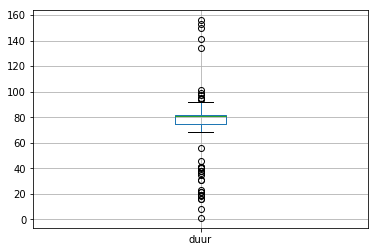

In [25]:
duurWrWk.boxplot('duur')

## Grafieken sluiten brug

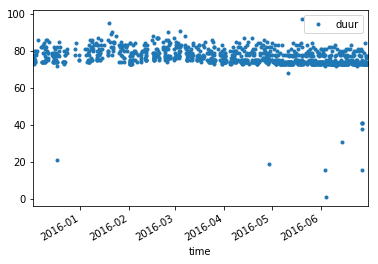

In [26]:
# duur tegenover tijd
sluit = duurWrWk[duurWrWk.beweging == True]
sluit.plot(x = "time", y = 'duur', style = '.')

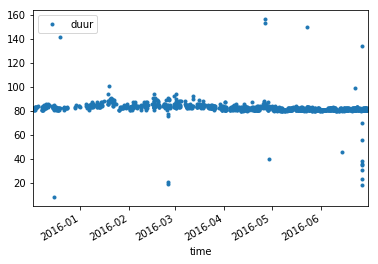

In [27]:
# Duur tegenover tijd
openen = duurWrWk[duurWrWk.beweging == False]
openen.plot(x = "time", y = 'duur', style = '.')

In [28]:
openen.duur.describe()

count    1181.000000
mean       82.253175
std         7.147081
min         8.000000
25%        81.000000
50%        82.000000
75%        83.000000
max       156.000000
Name: duur, dtype: float64

In [29]:
sluitin = sluit[sluit.duur > 75]
sluitout = sluit[sluit.duur < 75]

In [30]:
sluitin.shape

(518, 5)

In [31]:
sluitout.shape

(517, 5)

In [32]:
sluitPerOut = ((131/5821)*100)
sluitPerOut

2.2504724274179693

In [33]:
openin = openen[(openen.duur >= 75) & (openen.duur <= 125)]
openout = openen[(openen.duur < 75) | (openen.duur > 125)]

In [34]:
openin.shape

(1163, 5)

In [35]:
openout.shape

(18, 5)

In [36]:
openPerOut = ((258/5861)*100)
openPerOut

4.401979184439515

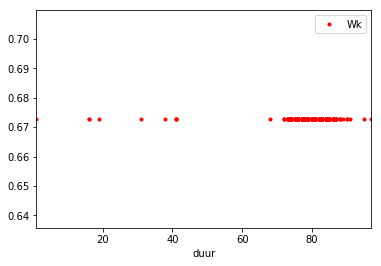

In [37]:
# duur tegenover windkracht
sluit.plot(x = "duur", y = 'Wk', style = '.', color = 'red')

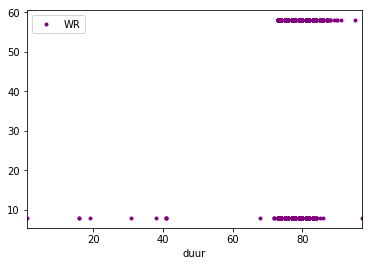

In [38]:
# Duur tegenover windrichting
sluit.plot(x = "duur", y = 'WR', style = '.', color = 'purple')

## Grafieken openen

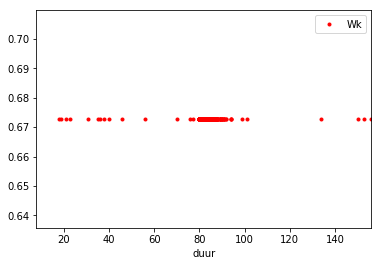

In [39]:
# Duur tegenover windkracht
openen.plot(x = "duur", y = 'Wk', style = '.', color = 'red')

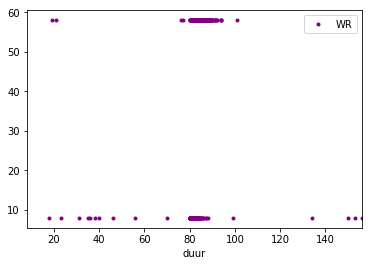

In [40]:
# Duur tegenover Windrichting
openen.plot(x = "duur", y = 'WR', style = '.', color = 'purple')

## Data Cleaning

In [41]:
# haal de outliers uit de data
cleanDuur = duurWrWk[duurWrWk.duur >  65]
cleanDuur = cleanDuur[cleanDuur.duur < 125]
cleanDuur.describe()

,duur,WR,Wk
count,2328.000000,2128.000000,2.128000e+03
mean,79.538230,31.214286,6.727430e-01
std,4.242874,24.942004,1.110484e-16
min,68.000000,8.000000,6.727430e-01
25%,75.000000,8.000000,6.727430e-01
50%,81.000000,8.000000,6.727430e-01
75%,82.000000,58.000000,6.727430e-01
max,101.000000,58.000000,6.727430e-01


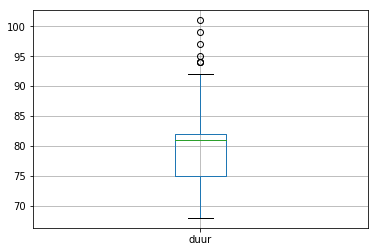

In [42]:
cleanDuur.boxplot('duur')

## Duur van openen bruggen over de tijd

In [43]:
cleanOpen = cleanDuur[cleanDuur.beweging == False]

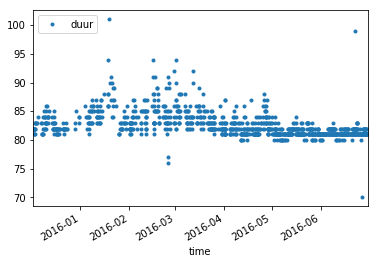

In [44]:
cleanOpen.plot(x = 'time', y ='duur', style = '.')

## Duur van sluiten bruggen over de tijd

In [45]:
cleanSluit = cleanDuur[cleanDuur.beweging == True]

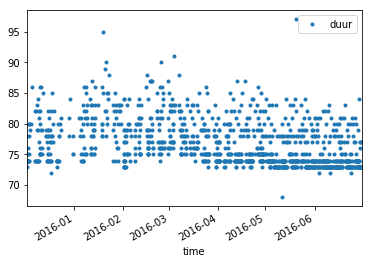

In [46]:
cleanSluit.plot(x = "time", y = 'duur', style = '.')

## data prep voor dagdeel

In [47]:
# Uur kolom maken om dagdeel te bepalen.
cleanOpen['uur'] = cleanOpen.time.dt.hour
cleanSluit['uur'] = cleanSluit.time.dt.hour
cleanDuur['uur'] = cleanDuur.time.dt.hour

c:\users\gebruiker\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
c:\users\gebruiker\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


# Boxplots
## Boxplots per dagdeel

([<matplotlib.axis.XTick at 0x14960930>,
 <a list of 4 Text xticklabel objects>)

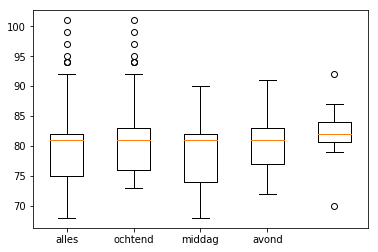

In [48]:
ochtendDuur = cleanDuur[((cleanDuur.uur >= 6)  & (cleanDuur.uur <= 12))]
middagDuur = cleanDuur[((cleanDuur.uur >= 13)  & (cleanDuur.uur <= 18))]
avondDuur = cleanDuur[((cleanDuur.uur >= 19)  & (cleanDuur.uur <= 24))]
nachtDuur = cleanDuur[((cleanDuur.uur >= 0)  & (cleanDuur.uur <= 5))]
data  = [cleanDuur.duur, ochtendDuur.duur, middagDuur.duur, avondDuur.duur, nachtDuur.duur]
plt.boxplot(data)
plt.xticks([1, 2, 3, 4], ('alles','ochtend', 'middag','avond', 'nacht'))

## Boxplot openen dagdeel

Text(0, 0.5, 'Duur (s)')

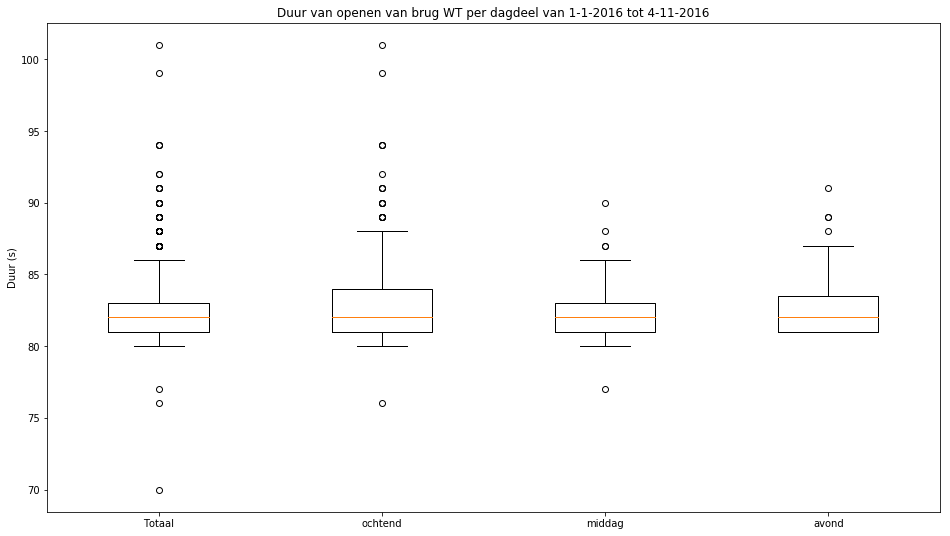

In [49]:
# maak nieuwe dataframes met daarin alle ochtend, middag en avond openingen.
# Deze brug opent in deze periode niet s'nachts

ochtendDuurOpen = cleanOpen[((cleanOpen.uur >= 6)  & (cleanOpen.uur <= 12))]
middagDuurOpen= cleanOpen[((cleanOpen.uur >= 13)  & (cleanOpen.uur <= 18))]
avondDuurOpen = cleanOpen[((cleanOpen.uur >= 19)  & (cleanOpen.uur <= 24))]

# selecteer de data om in de boxplot te zetten
dataOpen  = [cleanOpen.duur, ochtendDuurOpen.duur, middagDuurOpen.duur, avondDuurOpen.duur]

# Boxplot
plt.figure(figsize=(16,9))
plt.boxplot(dataOpen)
plt.xticks([1, 2, 3, 4], ('Totaal','ochtend', 'middag','avond'))
plt.title('Duur van openen van brug WT per dagdeel van 1-1-2016 tot 4-11-2016')
plt.ylabel('Duur (s)')

## Boxplot sluiten per dagdeel

Text(0, 0.5, 'Duur (s)')

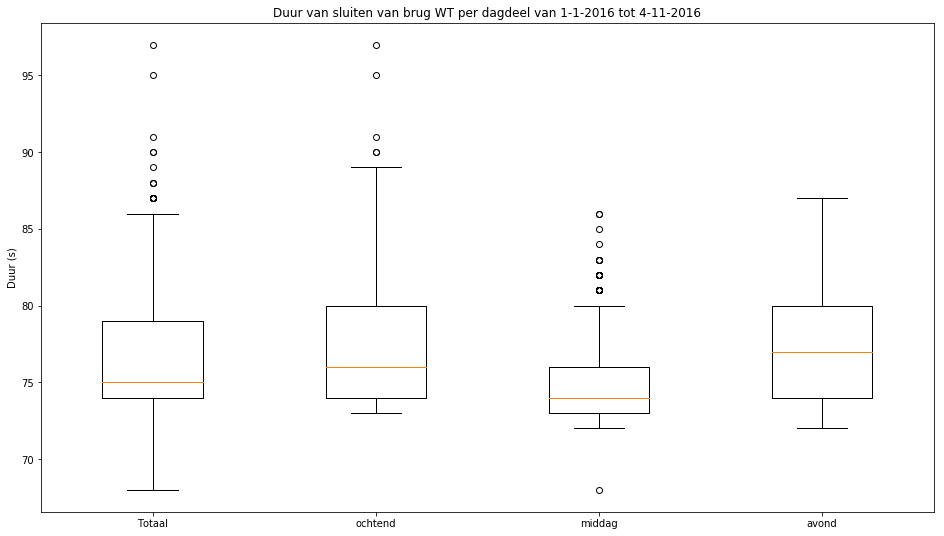

In [50]:
ochtendDuurSluit = cleanSluit[((cleanSluit.uur >= 6)  & (cleanSluit.uur <= 12))]
middagDuurSluit= cleanSluit[((cleanSluit.uur >= 13)  & (cleanSluit.uur <= 18))]
avondDuurSluit = cleanSluit[((cleanSluit.uur >= 19)  & (cleanSluit.uur <= 24))]
dataSluit  = [cleanSluit.duur, ochtendDuurSluit.duur, middagDuurSluit.duur, avondDuurSluit.duur]
plt.figure(figsize=(16,9))
plt.boxplot(dataSluit)
plt.xticks([1, 2, 3, 4], ('Totaal','ochtend', 'middag','avond'))
plt.title('Duur van sluiten van brug WT per dagdeel van 1-1-2016 tot 4-11-2016')
plt.ylabel('Duur (s)')

## Boxplots per windrichting

([<matplotlib.axis.XTick at 0x18098470>,
 <a list of 9 Text xticklabel objects>)

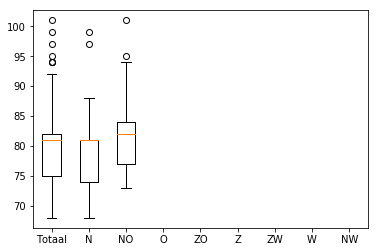

In [51]:
cleanDuur['N'] = ((cleanDuur.WR >= 0) & (cleanDuur.WR <= 22.5) | (cleanDuur.WR >= 337.6) & (cleanDuur.WR <= 360)).astype('int')
cleanDuur['NO'] = ((cleanDuur.WR >=22.6) & (cleanDuur.WR <= 67.5)).astype('int')
cleanDuur['O'] = ((cleanDuur.WR >=67.6) & (cleanDuur.WR <= 112.5)).astype('int')
cleanDuur['ZO'] = ((cleanDuur.WR >=112.6) & (cleanDuur.WR <= 157.5)).astype('int')
cleanDuur['Z'] = ((cleanDuur.WR >=157.6) & (cleanDuur.WR <= 202.5)).astype('int')
cleanDuur['ZW'] = ((cleanDuur.WR >=202.6) & (cleanDuur.WR <= 247.2)).astype('int')
cleanDuur['W'] = ((cleanDuur.WR>=247.6) & (cleanDuur.WR <= 292.5)).astype('int')
cleanDuur['NW'] = ((cleanDuur.WR >=292.6) & (cleanDuur.WR <= 337.5)).astype('int')

N = cleanDuur[cleanDuur.N == 1]
NO = cleanDuur[cleanDuur.NO == 1]
O = cleanDuur[cleanDuur.O == 1]
ZO = cleanDuur[cleanDuur.ZO == 1]
Z = cleanDuur[cleanDuur.Z == 1]
ZW = cleanDuur[cleanDuur.ZW == 1]
W = cleanDuur[cleanDuur.W == 1]
NW = cleanDuur[cleanDuur.NW == 1]

data = [cleanDuur.duur, N.duur,NO.duur,O.duur,ZO.duur,Z.duur, ZW.duur, W.duur, NW.duur]
plt.boxplot(data)
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9], ('Totaal','N','NO','O','ZO' ,'Z' ,'ZW','W','NW'))

## Boxplot duur openen per windrichting

Text(0, 0.5, 'Duur (s)')

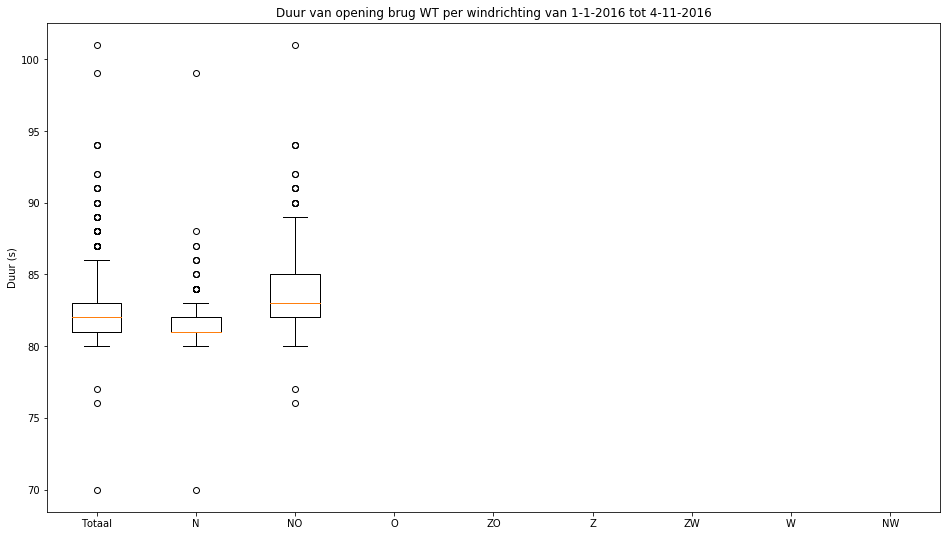

In [52]:
# dataframes aanmaken met alleen de data per windrichting, dus dataframe voor Noord, Oost, etc.
openN = cleanOpen[((cleanOpen.WR >= 0) & (cleanOpen.WR <= 22.5) | (cleanOpen.WR >= 337.6) & (cleanOpen.WR <= 360))]
openNO = cleanOpen[((cleanOpen.WR >=22.6) & (cleanOpen.WR <= 67.5))]
openO = cleanOpen[((cleanOpen.WR >=67.6) & (cleanOpen.WR <= 112.5))]
openZO = cleanOpen[((cleanOpen.WR >=112.6) & (cleanOpen.WR <= 157.5))]
openZ = cleanOpen[((cleanOpen.WR >=157.6) & (cleanOpen.WR <= 202.5))]
openZW = cleanOpen[((cleanOpen.WR >=202.6) & (cleanOpen.WR <= 247.2))]
openW = cleanOpen[((cleanOpen.WR>=247.6) & (cleanOpen.WR <= 292.5))]
openNW = cleanOpen[((cleanOpen.WR >=292.6) & (cleanOpen.WR <= 337.5))]

# selecteer data voor plot
data = [cleanOpen.duur, openN.duur,openNO.duur,openO.duur,openZO.duur,openZ.duur, openZW.duur, openW.duur, openNW.duur]

# Boxplot
plt.figure(figsize=(16,9))
plt.boxplot(data)
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9], ('Totaal','N','NO','O','ZO' ,'Z' ,'ZW','W','NW'))
plt.title('Duur van opening brug WT per windrichting van 1-1-2016 tot 4-11-2016')
plt.ylabel('Duur (s)')

## Boxplot duur sluiten per windrichting

Text(0, 0.5, 'Duur (s)')

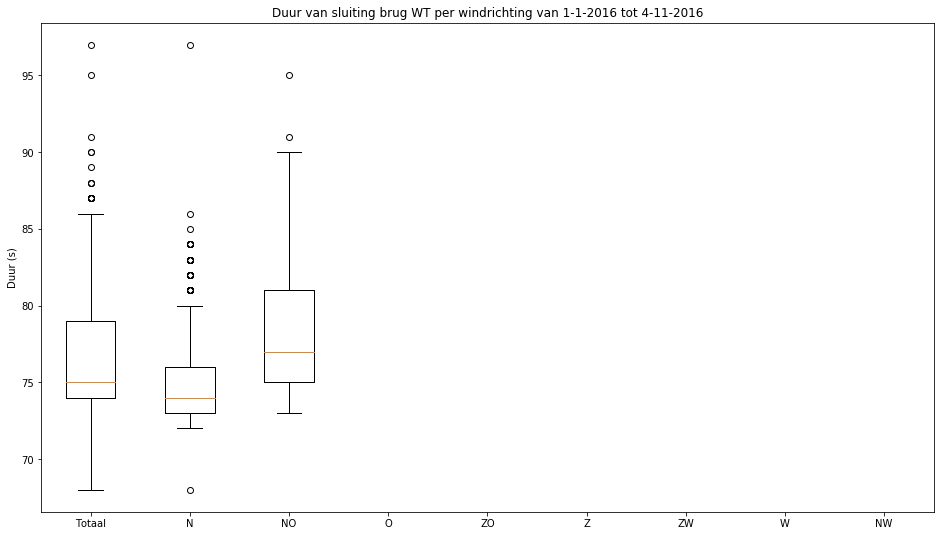

In [53]:
sluitN = cleanSluit[((cleanSluit.WR >= 0) & (cleanSluit.WR <= 22.5) | (cleanSluit.WR >= 337.6) & (cleanSluit.WR <= 360))]
sluitNO = cleanSluit[((cleanSluit.WR >=22.6) & (cleanSluit.WR <= 67.5))]
sluitO = cleanSluit[((cleanSluit.WR >=67.6) & (cleanSluit.WR <= 112.5))]
sluitZO = cleanSluit[((cleanSluit.WR >=112.6) & (cleanSluit.WR <= 157.5))]
sluitZ = cleanSluit[((cleanSluit.WR >=157.6) & (cleanSluit.WR <= 202.5))]
sluitZW = cleanSluit[((cleanSluit.WR >=202.6) & (cleanSluit.WR <= 247.2))]
sluitW = cleanSluit[((cleanSluit.WR>=247.6) & (cleanSluit.WR <= 292.5))]
sluitNW = cleanSluit[((cleanSluit.WR >=292.6) & (cleanSluit.WR <= 337.5))]

data = [cleanSluit.duur, sluitN.duur,sluitNO.duur,sluitO.duur,sluitZO.duur,sluitZ.duur, sluitZW.duur, sluitW.duur, sluitNW.duur]

plt.figure(figsize=(16,9))
plt.boxplot(data)
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9], ('Totaal','N','NO','O','ZO' ,'Z' ,'ZW','W','NW'))
plt.title('Duur van sluiting brug WT per windrichting van 1-1-2016 tot 4-11-2016')
plt.ylabel('Duur (s)')

# Scatter duur openen

In [54]:
wrbin = list()
for index, row in cleanOpen.iterrows():
    wr = row[3]
    wk = row[4]
    if(((wr >= 0) & (wr<=22.5))| ((wr >= 337.6) & (wr<=360))):
        wrbin.append(0)      
    elif((wr >= 22.6) & (wr<=67.5)):
        wrbin.append(1)
    elif((wr >= 67.6) & (wr<=112.5)):
        wrbin.append(2)
    elif((wr >= 112.6) & (wr<=157.5)):
        wrbin.append(3)
    elif((wr >= 157.6) & (wr<=202.5)):
        wrbin.append(4)
    elif((wr >= 202.6) & (wr<=247.5)):
        wrbin.append(5)
    elif((wr >= 247.6) & (wr<=292.5)):
        wrbin.append(6)
    elif((wr >= 292.6) & (wr<=337.5)):
        wrbin.append(7)
cleanOpen['WRbin'] = wrbin
cleanOpen.head()

ValueError: Length of values does not match length of index

In [ ]:
cleanOpen.Wk.describe()

In [ ]:
wkbin = list()
for index, row in cleanOpen.iterrows():
    wk = row[4]
    if((wk >= 0) & (wk<=0.2)):
        wkbin.append(0)      
    elif((wk > 0.2) & (wk<=1.5)):
        wkbin.append(1)
    elif((wk > 1.5) & (wk<=3.3)):
        wkbin.append(2)
    elif((wk > 3.3) & (wk<=5.4)):
        wkbin.append(3)
    elif((wk > 5.4) & (wk<=7.9)):
        wkbin.append(4)
    elif((wk > 7.9) & (wk<=10.7)):
        wkbin.append(5)
    elif((wk > 10.7) & (wk<=13.8)):
        wkbin.append(6)
    elif((wk > 13.8) & (wk<=17.1)):
        wkbin.append(7)
    elif((wk > 17.1) & (wk<=20.7)):
        wkbin.append(8)   
    elif((wk > 20.7) & (wk<=24.4)):
        wkbin.append(9)
    elif((wk > 24.4) & (wk<=28.4)):
        wkbin.append(10)
cleanOpen['WKbin'] = wkbin
cleanOpen.head()


In [ ]:
fig, ax = plt.subplots()
scatter = ax.scatter(cleanOpen.WR, cleanOpen.duur, c = cleanOpen.WRbin,  s=50, cmap='gnuplot')
ax.set_title("Duur per windrichting")

In [ ]:
fig, ax = plt.subplots()
scatter = ax.scatter(cleanOpen.WR, cleanOpen.duur, c = cleanOpen.WKbin,  s=50, cmap='gnuplot')
ax.set_title("Duur per windrichting")

In [ ]:
fig, ax = plt.subplots()
scatter = ax.scatter(cleanOpen.Wk, cleanOpen.duur, c = cleanOpen.WKbin,  s=50, cmap='gnuplot')
ax.set_title("Duur per windkracht")

In [ ]:
fig, ax = plt.subplots()
scatter = ax.scatter(cleanOpen.Wk, cleanOpen.duur, c = cleanOpen.WRbin,  s=50, cmap='gnuplot')
ax.set_title("Duur per windkracht")

# Scatter duur sluiten

In [ ]:
wrbin = list()
for index, row in cleanSluit.iterrows():
    wr = row[3]
    wk = row[4]
    if(((wr >= 0) & (wr<=22.5))| ((wr >= 337.6) & (wr<=360))):
        wrbin.append(0)      
    elif((wr >= 22.6) & (wr<=67.5)):
        wrbin.append(1)
    elif((wr >= 67.6) & (wr<=112.5)):
        wrbin.append(2)
    elif((wr >= 112.6) & (wr<=157.5)):
        wrbin.append(3)
    elif((wr >= 157.6) & (wr<=202.5)):
        wrbin.append(4)
    elif((wr >= 202.6) & (wr<=247.5)):
        wrbin.append(5)
    elif((wr >= 247.6) & (wr<=292.5)):
        wrbin.append(6)
    elif((wr >= 292.6) & (wr<=337.5)):
        wrbin.append(7)
cleanSluit['WRbin'] = wrbin
cleanSluit.head()

In [ ]:
wkbin = list()
for index, row in cleanSluit.iterrows():
    wk = row[4]
    if((wk >= 0) & (wk<=0.2)):
        wkbin.append(0)      
    elif((wk > 0.2) & (wk<=1.5)):
        wkbin.append(1)
    elif((wk > 1.5) & (wk<=3.3)):
        wkbin.append(2)
    elif((wk > 3.3) & (wk<=5.4)):
        wkbin.append(3)
    elif((wk > 5.4) & (wk<=7.9)):
        wkbin.append(4)
    elif((wk > 7.9) & (wk<=10.7)):
        wkbin.append(5)
    elif((wk > 10.7) & (wk<=13.8)):
        wkbin.append(6)
    elif((wk > 13.8) & (wk<=17.1)):
        wkbin.append(7)
    elif((wk > 17.1) & (wk<=20.7)):
        wkbin.append(8)   
    elif((wk > 20.7) & (wk<=24.4)):
        wkbin.append(9)
    elif((wk > 24.4) & (wk<=28.4)):
        wkbin.append(10)
cleanSluit['WKbin'] = wkbin
cleanSluit.head()

In [ ]:
fig, ax = plt.subplots()
scatter = ax.scatter(cleanSluit.WR, cleanSluit.duur, c = cleanSluit.WRbin,  s=50, cmap='gnuplot')
ax.set_title("Duur per windrichting")

In [ ]:
fig, ax = plt.subplots()
scatter = ax.scatter(cleanSluit.duur, cleanSluit.WR,  c = cleanSluit.WKbin,  s=50, cmap='gnuplot')
ax.set_title("Duur per windrichting")

In [ ]:
fig, ax = plt.subplots()
scatter = ax.scatter(cleanSluit.WR, cleanSluit.duur, c = cleanSluit.WKbin,  s=50, cmap='gnuplot')
ax.set_title("Duur per windrichting")

In [ ]:
fig, ax = plt.subplots()
scatter = ax.scatter(cleanSluit.Wk, cleanSluit.duur, c = cleanSluit.WKbin,  s=50, cmap='gnuplot')
ax.set_title("Duur per windkracht")

In [ ]:
fig, ax = plt.subplots()
scatter = ax.scatter(cleanSluit.Wk, cleanSluit.duur, c = cleanSluit.WRbin,  s=50, cmap='gnuplot')
ax.set_title("Duur per windkracht")

In [ ]:
wrbin = list()
for index, row in openen.iterrows():
    wr = row[3]
    wk = row[4]
    if(((wr >= 0) & (wr<=22.5))| ((wr >= 337.6) & (wr<=360))):
        wrbin.append(0)      
    elif((wr >= 22.6) & (wr<=67.5)):
        wrbin.append(1)
    elif((wr >= 67.6) & (wr<=112.5)):
        wrbin.append(2)
    elif((wr >= 112.6) & (wr<=157.5)):
        wrbin.append(3)
    elif((wr >= 157.6) & (wr<=202.5)):
        wrbin.append(4)
    elif((wr >= 202.6) & (wr<=247.5)):
        wrbin.append(5)
    elif((wr >= 247.6) & (wr<=292.5)):
        wrbin.append(6)
    elif((wr >= 292.6) & (wr<=337.5)):
        wrbin.append(7)
openen['WRbin'] = wrbin
openen.head()

In [ ]:
wkbin = list()
for index, row in openen.iterrows():
    wk = row[4]
    if((wk >= 0) & (wk<=0.2)):
        wkbin.append(0)      
    elif((wk > 0.2) & (wk<=1.5)):
        wkbin.append(1)
    elif((wk > 1.5) & (wk<=3.3)):
        wkbin.append(2)
    elif((wk > 3.3) & (wk<=5.4)):
        wkbin.append(3)
    elif((wk > 5.4) & (wk<=7.9)):
        wkbin.append(4)
    elif((wk > 7.9) & (wk<=10.7)):
        wkbin.append(5)
    elif((wk > 10.7) & (wk<=13.8)):
        wkbin.append(6)
    elif((wk > 13.8) & (wk<=17.1)):
        wkbin.append(7)
    elif((wk > 17.1) & (wk<=20.7)):
        wkbin.append(8)   
    elif((wk > 20.7) & (wk<=24.4)):
        wkbin.append(9)
    elif((wk > 24.4) & (wk<=28.4)):
        wkbin.append(10)
openen['WKbin'] = wkbin
openen.head()

# Dataframe omzetten naar CSV


In [ ]:
cleanOpen.to_csv('DuurOpening.csv')
cleanSluit.to_csv('DuurSluiten.csv')
cleanDuur.to_csv('CleanedDuur.csv')
openen.to_csv('Open.csv')
sluit.to_csv('Sluiten.csv')